# Fashion-MNIST

In [ ]:
! pip uninstall tensorflow

Uninstalling tensorflow-2.4.1:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.4.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.4.1


In [ ]:
! pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 43kB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 512kB 51.5MB/s 
     |████████████████████████████████| 3.8MB 49.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=7ec650f206ec6020370f057bfe4c8956d433177991068175429d493297955d38
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninsta

In [ ]:
import tensorflow as tf

print(tf.__version__)

1.15.0


## Modules

In [ ]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

## Data preprocessing

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


(60000, 785)

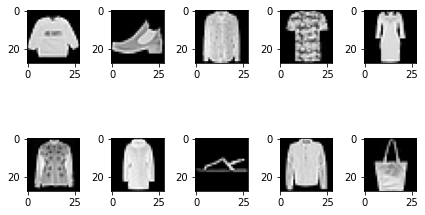

In [ ]:
# 1. Raw Data Loading
df = pd.read_csv('/content/drive/MyDrive/ML Colab/data/fashion-mnist/fashion-mnist_train.csv')
display(df.head(), df.shape) # (60000, 785)

# 2. 결측치, 이상치 없음

# 3. 이미지 데이터(픽셀 정보) 확인
img_data = df.drop('label', axis=1, inplace=False).values # 2차원 ndarray

fig = plt.figure()
fig_arr = list()
for n in range(10):
    fig_arr.append(fig.add_subplot(2,5,n+1))
    fig_arr[n].imshow(img_data[n].reshape(28,28), cmap='gray') # 행 픽셀 정보(2차원 ndarray) + cmap
plt.tight_layout()
plt.show()

# 4. data split (7:3)
x_data_train, x_data_test, t_data_train, t_data_test = \
train_test_split(df.drop('label', axis=1, inplace=False), df['label'],
                 test_size=0.3, random_state=0)

# 5. 정규화 처리 (x_data)
scaler = MinMaxScaler()
scaler.fit(x_data_train)
x_data_train_norm = scaler.transform(x_data_train)

scaler.fit(x_data_test)
x_data_test_norm = scaler.transform(x_data_test)

# 6. One-hot Encoding (t_data)
sess = tf.Session()
t_data_train_onehot = sess.run(tf.one_hot(t_data_train, depth=10))
t_data_test_onehot = sess.run(tf.one_hot(t_data_test, depth=10))

## Deep Neutral Network_TF1.15 (88%)

### Tensorflow Graph

In [ ]:
# Placeholder
X = tf.placeholder(shape=[None,784], dtype=tf.float32)
T = tf.placeholder(shape=[None,10], dtype=tf.float32)

# Weight, bias
W2 = tf.get_variable('W2', shape=[784,256],
                     initializer=tf.contrib.layers.variance_scaling_initializer())
b2 = tf.Variable(tf.random.normal([256]))
layer2 = tf.nn.relu(tf.matmul(X,W2) + b2)

W3 = tf.get_variable('W3', shape=[256,128],
                     initializer=tf.contrib.layers.variance_scaling_initializer())
b3 = tf.Variable(tf.random.normal([128]))
layer3 = tf.nn.relu(tf.matmul(layer2,W3) + b3)
#_layer3 = tf.nn.dropout(layer3, rate=0.3)

W4 = tf.get_variable('W4', shape=[128,32],
                     initializer=tf.contrib.layers.variance_scaling_initializer())
b4 = tf.Variable(tf.random.normal([32]))
layer4 = tf.nn.relu(tf.matmul(layer3,W4) + b4)

W5 = tf.get_variable('W5', shape=[32, 10],
                     initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random.normal([10]))

# Hypothesis
logit = tf.matmul(layer4,W5) + b5
H = tf.nn.softmax(logit)

# Loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, labels=T))

# Gradient Descent Algorithm
train = tf.train.GradientDescentOptimizer(learning_rate=1e-1).minimize(loss)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### Learning

In [ ]:
# Batch
num_of_epoch = 1000
batch_size = 512

# Learning
def run_train(sess, train_x, train_t): # x_data_train_norm, t_data_train_onehot
    print('=====START LEARNING=====')
    
    # 초기화
    sess.run(tf.global_variables_initializer())
    
    # 반복학습
    for step in range(num_of_epoch):
        total_batch = int(train_x.shape[0] / batch_size)
        
        for i in range(total_batch):
            batch_x = train_x[i*batch_size:(i+1)*batch_size] 
            batch_t = train_t[i*batch_size:(i+1)*batch_size]
            _, loss_val = sess.run([train, loss], feed_dict={X: batch_x, T: batch_t})
        ## 여기까지 1 epoch
            
        if step % 100 == 0:
            print('Loss: {}'.format(loss_val))
    
    print('=====FINISH LEARNING=====')

### Accuracy

In [ ]:
# Accuracy
predict = tf.argmax(H, 1) 
correct = tf.equal(predict, tf.argmax(T, 1)) 
accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32)) 

### Validation

In [ ]:
# K-fold Cross Validation
cv = 5      
results = [] 

kf = KFold(n_splits=cv, shuffle=True) 

for training_idx, validation_idx in kf.split(x_data_train_norm): 
    
    training_x = x_data_train_norm[training_idx] 
    training_t = t_data_train_onehot[training_idx]
    
    validation_x = x_data_train_norm[validation_idx]
    validation_t = t_data_train_onehot[validation_idx]
    
    # 1. training data로 learning
    run_train(sess, training_x, training_t)
    
    # 2. testing data로 validation: #1에서 만든 학습모델에 대한 정확도(성능평가) 측정
    results.append(sess.run(accuracy, feed_dict={X:validation_x, T: validation_t}))
    
print('측정한 각 Fold의 정확도: {}'.format(results))

final_acc = np.mean(results)
print('K-Fold Validation을 통한 우리 모델의 최종 Accuracy: {}'.format(final_acc))

=====START LEARNING=====
Loss: 0.9222245216369629
Loss: 0.1233169212937355
Loss: 0.028918657451868057
Loss: 0.003273752983659506
Loss: 0.0010611972538754344
Loss: 0.0005429755547083914
Loss: 0.00033203186467289925
Loss: 0.00023179173876997083
Loss: 0.00017626502085477114
Loss: 0.00014294098946265876
=====FINISH LEARNING=====
=====START LEARNING=====
Loss: 0.8999131321907043
Loss: 0.191732719540596
Loss: 0.03543344512581825
Loss: 0.00421837717294693
Loss: 0.0010285759344696999
Loss: 0.0005729830591008067
Loss: 0.00036446069134399295
Loss: 0.00025227476726286113
Loss: 0.00018950145749840885
Loss: 0.00015070523659233004
=====FINISH LEARNING=====
=====START LEARNING=====
Loss: 0.7524614930152893
Loss: 0.1843920797109604
Loss: 0.0258139967918396
Loss: 0.002734130248427391
Loss: 0.0008494032081216574
Loss: 0.0004485537647269666
Loss: 0.0002909204049501568
Loss: 0.00021355821809265763
Loss: 0.0001670961792115122
Loss: 0.00013646289880853146
=====FINISH LEARNING=====
=====START LEARNING=====
L

### Evaluation

In [ ]:
run_train(sess, training_x, training_t)
final_accuracy = sess.run(accuracy, feed_dict={X: x_data_test_norm, T: t_data_test_onehot})
print('우리 모델의 최종 정확도: {}'.format(final_accuracy))
print('\n')

# classification_report
predict_data = sess.run(predict, feed_dict={X: x_data_test_norm, T: t_data_test_onehot})
final_testing = classification_report(t_data_test, predict_data)
print(final_testing)

=====START LEARNING=====
Loss: 0.8805751800537109
Loss: 0.14978957176208496
Loss: 0.19806575775146484
Loss: 0.02803644724190235
Loss: 0.0023687647189944983
Loss: 0.0008666347712278366
Loss: 0.0004778795118909329
Loss: 0.00031908811070024967
Loss: 0.00023387644614558667
Loss: 0.00018389843171462417
=====FINISH LEARNING=====
우리 모델의 최종 정확도: 0.8824999928474426


              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1799
           1       0.98      0.98      0.98      1843
           2       0.80      0.83      0.82      1808
           3       0.89      0.89      0.89      1849
           4       0.80      0.80      0.80      1765
           5       0.96      0.95      0.96      1786
           6       0.71      0.68      0.70      1787
           7       0.94      0.95      0.94      1789
           8       0.96      0.96      0.96      1795
           9       0.95      0.96      0.96      1779

    accuracy                           0.88

### Testing

In [ ]:
test_raw_df = pd.read_csv('/content/drive/MyDrive/ML Colab/data/fashion-mnist/fashion-mnist_test.csv')
x_test = test_raw_df.drop('label', axis=1, inplace=False)
t_test = test_raw_df['label']

# normalization
x_test_norm = scaler.transform(x_test)

# prediction
test_result = sess.run(predict, feed_dict={X: x_test_norm})

# classification_report
final_result = classification_report(t_test, test_result)
print(final_result)

              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1000
           1       0.98      0.98      0.98      1000
           2       0.81      0.79      0.80      1000
           3       0.89      0.90      0.89      1000
           4       0.81      0.84      0.83      1000
           5       0.96      0.95      0.95      1000
           6       0.73      0.69      0.71      1000
           7       0.93      0.94      0.93      1000
           8       0.97      0.97      0.97      1000
           9       0.94      0.96      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

